In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
from natsort import natsorted

color_names = ["dusty purple", "orange", "dark tan", "pink", "baby blue", "olive", "sea blue", "dusty red", "faded green", "amber", "windows blue"]
colors = sns.xkcd_palette(color_names)

foundation_names = np.array(['Harm/Care', 'Fairness/Reciprocity', 'In-group/Loyalty', 'Authority/Respect', 'Purity/Sanctity'])

# The "-1" comes from the fact that Python begins indexing at 0.
Harm_Care = np.array([1,7,12,17,23,28])-1
Fairness_Reciprocity = np.array([2,8,13,18,24,29])-1
InGroup_Loyalty = np.array([3,9,14,19,25,30])-1
Authority_Respect = np.array([4,10,15,20,26,31])-1
Purity_Sanctity = np.array([5,11,16,21,27,32])-1

foundations = [Harm_Care, Fairness_Reciprocity, InGroup_Loyalty, Authority_Respect, Purity_Sanctity]

# These have been taken from 
avg_american_mod = np.array([20.2,20.5,16.0,16.5,12.6])/6
avg_american_libertarian = np.array([2.73, 3.09, 2.25, 2.16, 1.35])
std_american_libertarian = np.array([2.73, 3.09, 2.25, 2.16, 1.35])
avg_american_liberal = np.array([3.68, 3.76, 2.14, 2.12, 1.37])
std_american_liberal = np.array([3.68, 3.76, 2.14, 2.12, 1.37])
avg_american_conservative = np.array([3.03, 3.02, 3.12, 3.32, 3])
std_american_conservative = np.array([3.03, 3.02, 3.12, 3.32, 3])

results_mfq = natsorted(glob.glob('MFQ_Results/*.csv', recursive=True))
results_mfq

['MFQ_Results/MFQ Results - Claude-3-Sonnet.csv',
 'MFQ_Results/MFQ Results - GPT-3.5.csv',
 'MFQ_Results/MFQ Results - GPT-4.5.csv',
 'MFQ_Results/MFQ Results - Gemini-Pro.csv',
 'MFQ_Results/MFQ Results - Gemma-2B.csv',
 'MFQ_Results/MFQ Results - Llama-2.csv',
 'MFQ_Results/MFQ Results - Starling-LM-7B.csv']

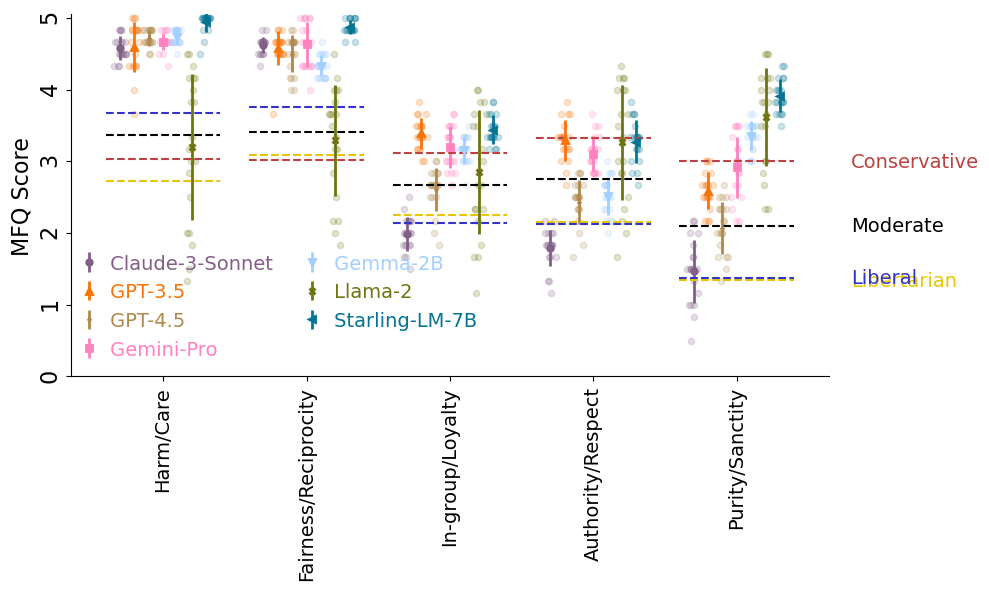

In [2]:
import matplotx as mpx

results_mfq = natsorted(glob.glob('responses/*.csv', recursive=True))
fig, ax = plt.subplots(figsize = (10, 6))
markers = ['o', '^', '2', 's', 'v', 'x','<']
political_labels = ['Average \nUS citizen', 'Libertarian', 'Liberal', 'Conservative']
model_names = []

scores = np.zeros((len(results_mfq), len(foundations), 20))
for rr, file in enumerate(results_mfq):
    if file.split('Results')[-1][2:-4] in [' Llama-2',' Starling-LM-7B',' Gemma-2B']:
        dat = pd.read_csv(file, delimiter=';')
    else:    
        dat = pd.read_csv(file)

    for ii, foundation in enumerate(foundations):
        for iter in range(dat.shape[1]):
            scores[rr, ii, iter] = np.mean(dat.values[foundation.astype(int), iter])
        plt.scatter(x = [np.arange(len(foundations))[ii]+0.1*rr]+np.random.random(size = dat.shape[1])*0.05-np.random.random(size = dat.shape[1])*0.05, 
                    y = scores[rr, ii,:], color = colors[rr], alpha = 0.2, s = 20)
    plt.errorbar(x = np.arange(len(foundations))+0.1*rr, y = np.mean(scores[rr,:,:], axis = 1), yerr = np.std(scores[rr,:,:], axis = 1), 
                 marker = markers[rr], color = colors[rr], mfc = colors[rr], ms = 4, ls = '', label = file.split('Results')[-1][2:-4], elinewidth = 2, mew = 2)
    model_names.append(file.split('Results')[-1][2:-4])
plt.legend(frameon = False, handlelength = 0, ncol = 2, labelcolor = 'linecolor', fontsize = 14)
for ii in range(len(foundations)):

    # Sample average values for each group
    x_positions = np.linspace(ii-0.1, ii + 0.7, 3)
    y_offset = 0
    if ii == len(foundations) -1 :
        plt.plot(x_positions, avg_american_mod[ii]*np.ones(3), ls = '--', color = 'black', label = 'Moderate')
        plt.plot(x_positions, avg_american_libertarian[ii]*np.ones(3), ls = '--', color = '#E5C601', label = 'Libertarian')
        plt.plot(x_positions, avg_american_liberal[ii]*np.ones(3), ls = '--', color = sns.desaturate('blue', 0.6), label = 'Liberal')
        plt.plot(x_positions, avg_american_conservative[ii]*np.ones(3), ls = '--', color = sns.desaturate('red',0.5), label = 'Conservative')
    else:
        plt.plot(x_positions, avg_american_mod[ii]*np.ones(3), ls = '--', color = 'black')
        plt.plot(x_positions, avg_american_libertarian[ii]*np.ones(3), ls = '--', color = '#E5C601')
        plt.plot(x_positions, avg_american_liberal[ii]*np.ones(3), ls = '--', color = sns.desaturate('blue', 0.6))
        plt.plot(x_positions, avg_american_conservative[ii]*np.ones(3), ls = '--', color = sns.desaturate('red',0.5))
    
plt.ylabel('MFQ Score', fontsize = 16)
plt.yticks(ticks = np.linspace(0, 5, 6), labels = np.linspace(0, 5, 6).astype(int), fontsize = 16, rotation = 90)
plt.xticks(ticks = np.arange(len(foundations))+0.3, labels = foundation_names, rotation = 90, fontsize = 14)
mpx.line_labels(fontsize = 14, min_label_distance=0.05)
plt.ylim([0., 5.05])
plt.tight_layout()
sns.despine()
#plt.savefig('MFQ_ModelResults_13042024.svg', transparent = True)

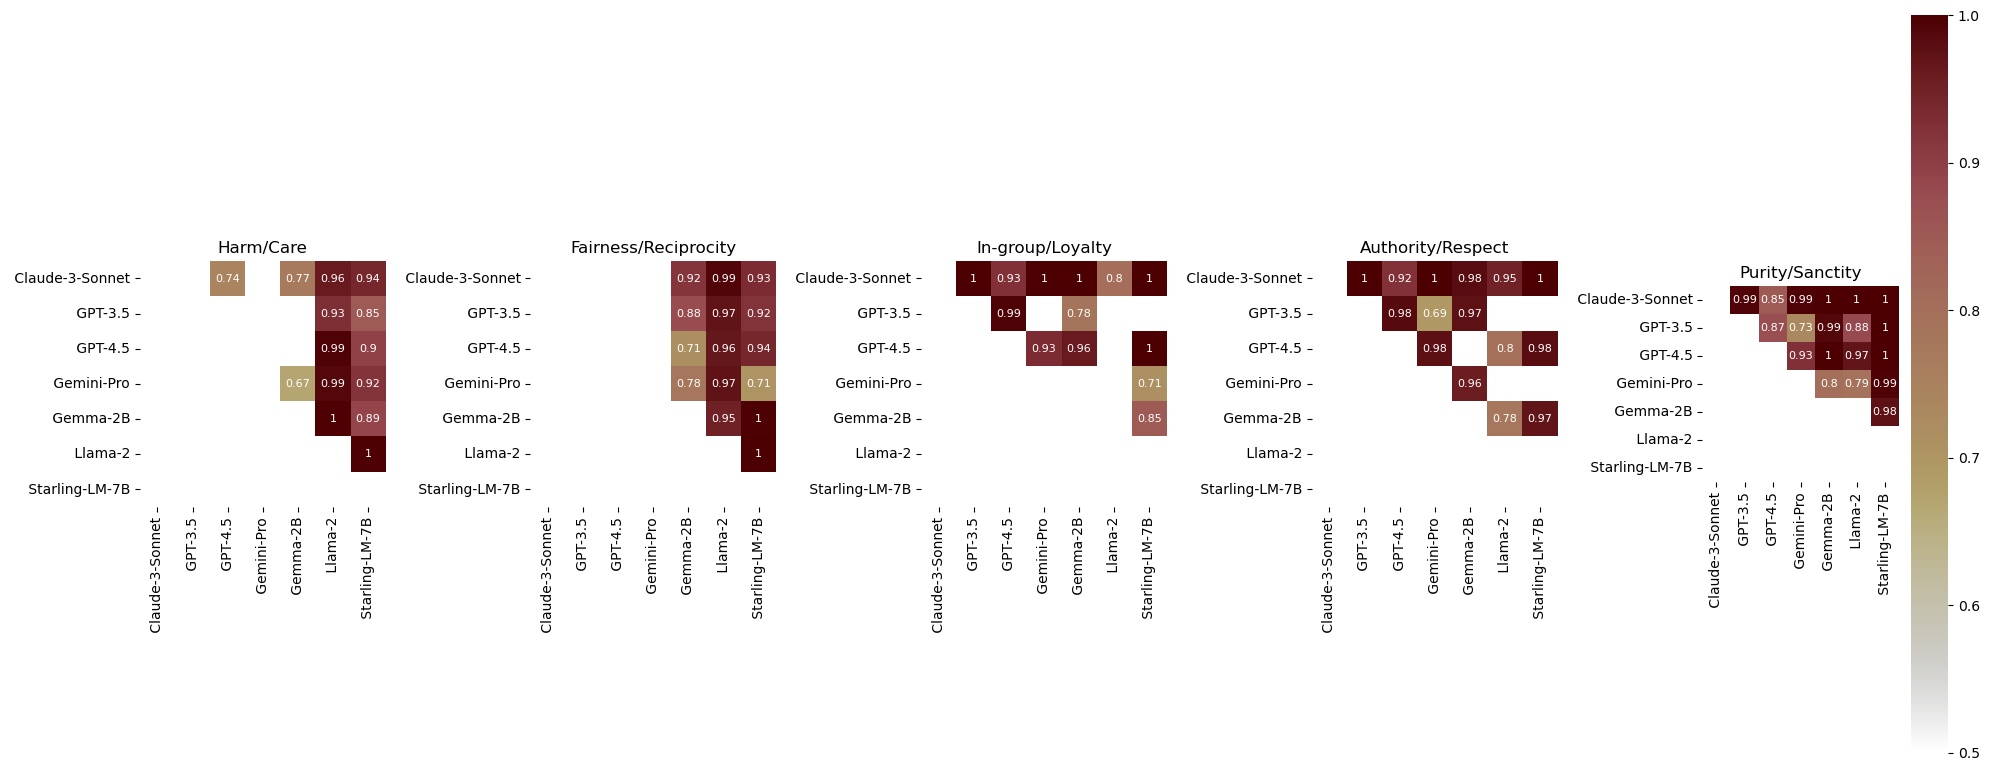

In [8]:
import numpy as np
import scipy.stats as stats
import statsmodels.stats.multitest as multitest
import matplotlib.pyplot as plt
import seaborn as sns
import cmcrameri as cmc

# Dummy data shape
n_models, n_features, n_observations = scores.shape

# Placeholder for p-values and effect sizes
p_values = np.zeros((n_features, n_models, n_models))
effect_sizes = np.full((n_features, n_models, n_models), np.nan)

# Perform Mann-Whitney U-tests
for feature in range(n_features):
    for i in range(n_models):
        for j in range(i + 1, n_models):
            result = stats.mannwhitneyu(scores[i, feature, :], scores[j, feature, :])
            p_values[feature, i, j] = result.pvalue
            effect_sizes[feature, i, j] = max(result.statistic/(scores.shape[2]**2), 1 - result.statistic/(scores.shape[2]**2))

# Adjust p-values using FDR
adj_p_values = np.full_like(p_values, np.nan)
for feature in range(n_features):
    _, adjusted, _, _ = multitest.multipletests(p_values[feature, :, :].ravel(), method='fdr_bh')
    adj_p_values[feature, :, :] = adjusted.reshape(n_models, n_models)

# Significance threshold
alpha = 0.05

fig, ax = plt.subplots(ncols = n_features, figsize=(20, 20))

# Visualization for each feature
for feature in range(n_features):
    
    # Mask for non-significant comparisons
    mask = adj_p_values[feature, :, :] > alpha
    np.fill_diagonal(mask, True)  # Mask diagonal for visual clarity
    
    # Create a masked effect size matrix for the current feature
    effect_sizes_masked = np.ma.masked_where(mask, effect_sizes[feature, :, :])
    
    # Plotting
    if feature == n_features-1:
            sns.heatmap(effect_sizes_masked, mask=mask, vmin = 0.5, vmax = 1, annot=True, cmap="cmc.bilbao_r", annot_kws={'fontsize':8}, cbar=True, square=True, ax= ax[feature])
    else:
        sns.heatmap(effect_sizes_masked, mask=mask, vmin = 0.5, vmax = 1, annot=True, cmap="cmc.bilbao_r", annot_kws={'fontsize':8}, cbar=False, square=True, ax= ax[feature])
    ax[feature].set_title(foundation_names[feature])
    ax[feature].set_yticks(ticks = np.arange(n_models)+0.5, labels = model_names, rotation = 0)
    ax[feature].set_xticks(ticks = np.arange(n_models)+0.5, labels = model_names, rotation = 90)
plt.tight_layout()
plt.savefig('EffectSizes_MFQ_22052024.svg', transparent = True)